# ポートとデバイスの基本
ファームウェアはポートに 0 から 3 までの番号を付けます。「現在のポート」という概念があり、port コマンドを使用して設定されます。

多くのコマンドは暗黙的に現在のポートをアドレス指定します。

各ポートにはデバイスが接続されている場合があります。 デバイスは「アクティブ」である可能性があります。これは、デバイスが HAT と通信していることを意味します。
シリアル インターフェイスを使用するか、「パッシブ」である可能性があります。

受動デバイスには一部のライトやモーターが含まれますが、ほとんどの種類のモーターは能動デバイスです。 アクティブ デバイスは HAT にフィードバックを提供できます。たとえば、アクティブ モーターには次のものが含まれる場合があります。
位置センサーまたは速度センサーを使用して、正確に制御できます。

アクティブなデバイスには最大 16 の「モード」があります。 モードは、デバイス内の小さなメモリ バッファと考えることができます。
Bluetooth 用語における「特性」の概念。

一部のモードは、デバイスを制御するために書き込まれることを目的としています。
センサーの読み取り値を抽出するなど、読み取りを目的としたものもあります。

デバイスが HAT に接続されると、HAT は「接続されました」メッセージに続いて、デバイスに関する情報を送信します。
デバイス。

パッシブデバイスの場合、これは単なる識別コード番号になります。

アクティブなデバイスの場合、これは識別コード番号であり、その後に接続ボー レート、ソフトウェアおよびハードウェアのバージョン番号、使用可能なモードのリストなどの他の情報が続きます。 詳細については、以下の list コマンドを参照してください。

デバイスが HAT から取り外されると、「切断されました」メッセージが表示されます。

HAT シリアル プロトコル ポートとデバイスの基本の構築 3 デバイスの電源
LPF2 コネクタは、2 つの方法で接続されたデバイスに電力を供給します。

1 つ目は、常に存在する +3.3V の通常のデジタル ロジック電源です。 デバイスがこの電源から過大な電流を引き出そうとすると、障害が続く限り「ポート電源障害」メッセージが表示されます。

2 番目の電源は約 +7.2V で、モーターやその他の比較的高出力のデバイスを駆動することを目的としています。

これは、ポートごとに個別の専用ドライバー IC によって供給されます。

この電源で障害が検出された場合は、「モーター電源障害」が発生します。
というメッセージが繰り返し出力されます。 この障害状態はハードウェアでラッチされるため、原因が判明した後に明示的にクリアする必要があります。
障害は解決されました。以下の clear_faults コマンドを参照してください。

モーター ドライバー IC は、どちらの極性の PWM 波形も出力して、モーターの速度と方向の制御を可能にします。


# オンボードコントローラー
ファームウェアは、HAT の各ポートにモーター電力出力用の独立したコントローラーを実装します。 コントローラーは、「ダイレクト PWM」(デフォルト) と「PID」の 2 つのモードのいずれかになります。

さらに、各コントローラーには関連するセットポイントがあり、これは一定または変化します。以下の set コマンドを参照してください。

ダイレクト PWM モードでは、設定値は –1 ～ +1 の範囲内である必要があり、電力出力を直接制御します。 これは、単純なモーター用途、ライトの駆動、および他の目的で「モーター電力」を使用する特定のデバイスに役立ちます。

このようなデバイスは通常、接続が確立された直後に電源を有効にする必要があります。
逆に駆動されます。つまり、-1 を設定します。

PID モードでは、比例積分微分コントローラーがセンサーから値を読み取ります。通常、これは制御されるモーターの速度センサーまたは角度センサーです。 この値は「プロセス変数」と呼ばれます。

PID コントローラーは出力電力を調整して、プロセス変数が設定値を厳密に追跡できるようにします。 これを使用すると、たとえば、負荷が変化してもモーターを一定速度で実行したり、モーターを特定の位置に移動したりすることができます。 詳細については、以下の pid コマンドを参照してください。

In [104]:
import math
import copy
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import control
import datetime

from control import matlab
from control.matlab import *
from scipy import signal

from Modules import Modules


%matplotlib inline

print("OK\n")

OK



In [105]:
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y  

In [106]:
def calc_poly(df_value):
    #近似式の係数
    y = df_value
    res1=np.polyfit(x, y, 1)
    res2=np.polyfit(x, y, 2)
    res3=np.polyfit(x, y, 3)
    #近似式の計算
    y1 = np.poly1d(res1)(x) #1次
    y2 = np.poly1d(res2)(x) #2次
    y3 = np.poly1d(res3)(x) #3次
    
    #グラフ表示
    plt.scatter(x, y, label='元データ')
    plt.plot(x, y1, label='1次')
    plt.plot(x, y2, label='2次')
    plt.plot(x, y3, label='3次')
    plt.legend()
    plt.show()
    return y1,y2,y3

In [107]:
# 2次系伝達関数モデル作成の関数
def tf_2nd_order(zeta, wn):
   num = [math.pow(wn, 2)]
   den = [1, 2*zeta*wn, math.pow(wn, 2)]
   G = matlab.tf(num, den)
   return G

In [108]:
def get_peak(output, t):
    t_peak = 0
    a_max = 0
    for i, y in enumerate(output):
        if y > a_max:
            a_max = y
            t_peak = t[i]
    return a_max, t_peak

In [109]:
def calc_param_ab(a_max, t_peak, Kp, z_c):
    gumma_c = (1/t_peak) * math.log1p((z_c/a_max))
    delta_c = math.pi/t_peak
    omega_nc = math.sqrt(math.pow(gumma_c, 2) + math.pow(delta_c, 2))
    zeta_c = gumma_c/omega_nc
    print("omega_nc : " +str(omega_nc))
    print("zeta_c : " + str(zeta_c))
    a_m = 2 * zeta_c * omega_nc
    b_m = ((math.pow(omega_nc, 2))/Kp)
    return a_m, b_m

In [110]:
def plot_line(output, t, z_c, x_max, y_max):
    # 出力パラメータ
    plt.plot(t, z_c * output)
    plt.axhline(z_c, ls=":", color="blue")
    
    # グラフ表示設定
    plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
    plt.title('2nd order step', fontsize=10)        # グラフタイトル
    plt.xlabel('time [sec]', fontsize=10)           # x軸ラベル
    plt.ylabel('Output', fontsize=10)               # y軸ラベル
    plt.xlim([0, x_max])                              # x軸範囲
    plt.ylim([0, y_max])                              # y軸範囲
    plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
    plt.tight_layout()                              # ラベルがきれいに収まるよう表示
    plt.grid()                                      # グリッド表示
    plt.show()    

<Axes: >

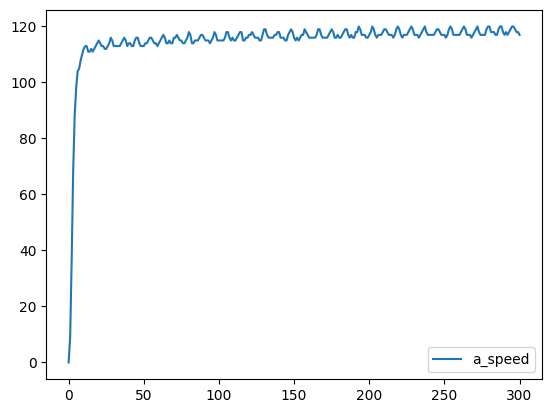

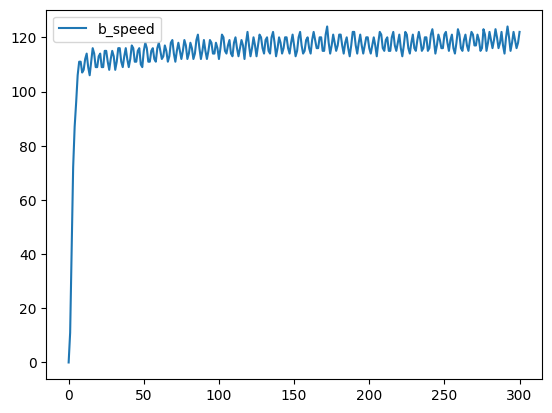

In [111]:
file_index = '01'
df = pd.read_csv('/home/uecadmin/testScript/param_pwm-0.5_001_1697868479.9057634.tsv')
df.plot(y='a_speed')
df.plot(y='b_speed')

In [25]:
# https://atatat.hatenablog.com/entry/data_proc_python4
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html
time = 6.727645635604856
samplerate = 44.59212274979287
fp = 3.1 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 10# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 20 # 通過域端最大損失[dB]
gstop = 21 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

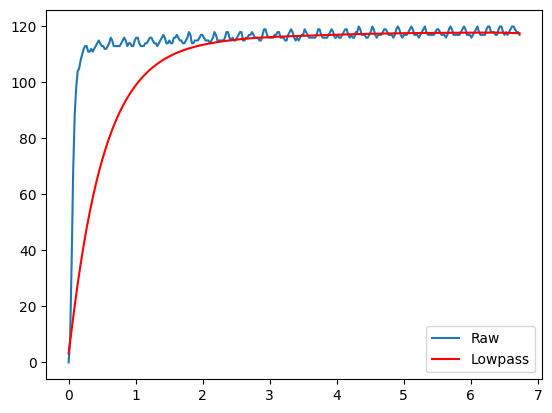

In [26]:
a_df_int = df['a_speed'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])

In [27]:
df

,delta,a_speed,a_position,b_speed,b_position
0,0.272383,0,13745,0,15664
1,0.023470,9,13770,11,15691
2,0.023222,36,13802,41,15724
3,0.024566,68,13840,72,15759
4,0.023755,88,13881,87,15800
...,...,...,...,...,...
296,0.021380,120,26057,122,27985
297,0.021384,119,26097,119,28025
298,0.021371,118,26137,116,28066
299,0.023465,118,26183,118,28116


In [41]:
calc_data = []
before_dps_a = 0
before_dps_b = 0
time = 0
for index, row in df.iterrows():
    time = time + row['delta']
    if index == 0:
        delta_theata_a = 0
        delta_theata_b = 0
        dps_a = 0
        dps_b = 0
        delta_a_speed = 0
        delta_b_speed = 0
        delta_a_dps = 0
        delta_b_dps = 0
        rps_a = 0
        rps_b = 0
        acc_a = 0
        acc_b = 0
        accr_a = 0
        accr_b = 0
    else:
        # 1ステップ前の相対角度(観測値)との差分から⊿θを導出
        delta_theata_a = row['a_position'] - df['a_position'][index - 1]
        delta_theata_b = row['b_position'] - df['b_position'][index - 1]
        # １ステップ前からの角度の変化量⊿θと時間変化⊿tの商から角速度deg/secを導出
        dps_a = delta_theata_a/row['delta']
        dps_b = delta_theata_b/row['delta']
        # １ステップ前との速度変化(観測値)を導出
        delta_a_speed = (row['a_speed'] - df['a_speed'][index - 1])
        delta_b_speed = (row['b_speed'] - df['b_speed'][index - 1])
        # 1ステップ前の角速度との差分から⊿ωを導出
        delta_a_dps = dps_a - before_dps_a
        delta_b_dps = dps_b - before_dps_b
        #
        rps_a = dps_a * math.pi/180
        rps_b = dps_b * math.pi/180
        # 速度の変化量と⊿tの商から角加速度deg/sec^2 を導出
        acc_a = delta_a_dps / row['delta']
        acc_b = delta_b_dps / row['delta']
        #
        accr_a = acc_a * math.pi/180
        accr_b = acc_b * math.pi/180
    # 行データを配列にセット
    line = {
        'delta': row['delta']
        ,'time': time
        ,'acc_a': acc_a
        ,'dps_a': dps_a
        ,'rps_a': rps_a
        ,'accr_a': accr_a
        ,'a_speed': row['a_speed']
        ,'delta_a_speed': delta_a_speed
        ,'delta_a_dps': delta_a_dps
        ,'delta_theata_a': delta_theata_a
        ,'a_position': row['a_position']
        ,'acc_b': acc_b
        ,'dps_b': dps_b
        ,'rps_b': rps_b
        ,'accr_b': accr_b
        ,'b_speed': row['b_speed']
        ,'delta_b_dps': delta_b_dps
        ,'delta_b_speed': delta_b_speed
        ,'delta_theata_b': delta_theata_b
        ,'b_position': row['b_position']
    }
    calc_data.append(line)
    before_dps_a = dps_a
    before_dps_b = dps_b

df2 = pd.DataFrame(calc_data)
samplerate = 1.0 / (time / 300)
print(time)
print(samplerate)

7.21775698661804
41.56415913644778


In [42]:
fp = 4.5 # 通過域端周波数[Hz]
fs = 12 # 阻止域端周波数[Hz]
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate  

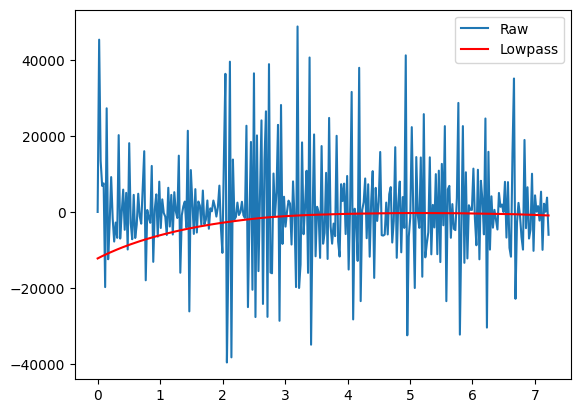

In [43]:
a_df_acc_a = df2['acc_a'].values
data_lofilt = lowpass(a_df_acc_a, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_acc_a)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df2['acc_a_filterd'] = data_lofilt

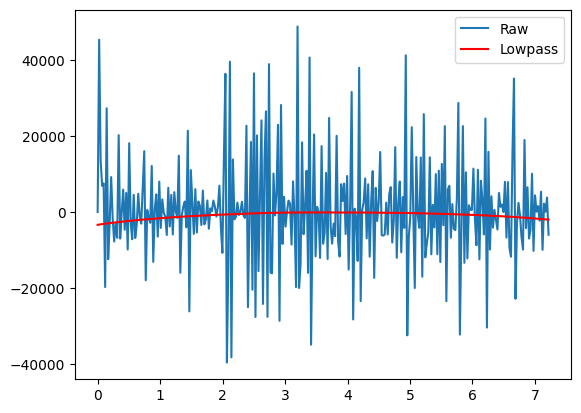

In [44]:
a_df_acc_b = df2['acc_b'].values
data_lofilt = lowpass(a_df_acc_b, samplerate, fp, fs, gpass, gstop)
plt.plot(x, a_df_acc_a)
plt.plot(x, data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df2['acc_b_filterd'] = data_lofilt

In [78]:
fp = 6.8 # 通過域端周波数[Hz]
fs = 12 # 阻止域端周波数[Hz]
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate  

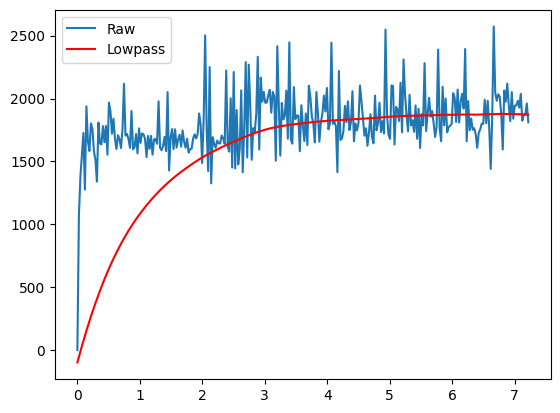

In [79]:
a_df_dps_a = df2['dps_a'].values
data_lofilt = lowpass(a_df_dps_a, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_dps_a)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df2['dps_a_filterd'] = data_lofilt

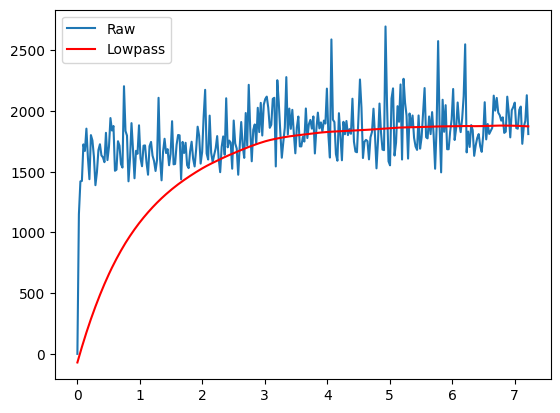

In [80]:
a_df_dps_b = df2['dps_b'].values
data_lofilt = lowpass(a_df_dps_b, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_dps_b)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df2['dps_b_filterd'] = data_lofilt

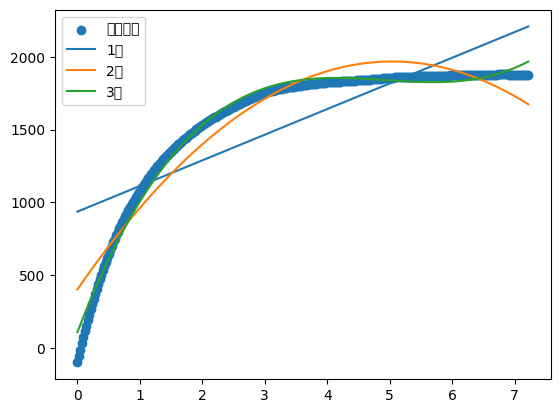

In [82]:
y1, y2, y3 = calc_poly(df2['dps_a_filterd'])

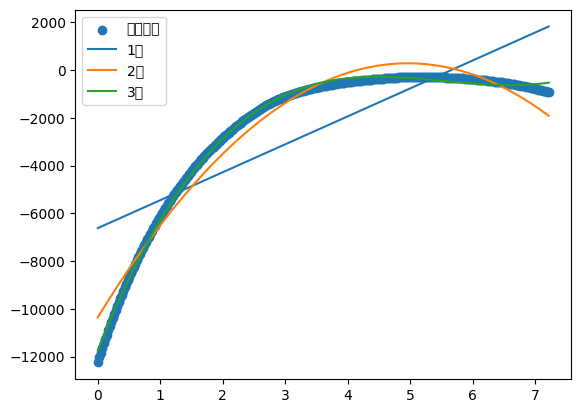

In [83]:
y1, y2, y3 = calc_poly(df2['acc_a_filterd'])

<Axes: >

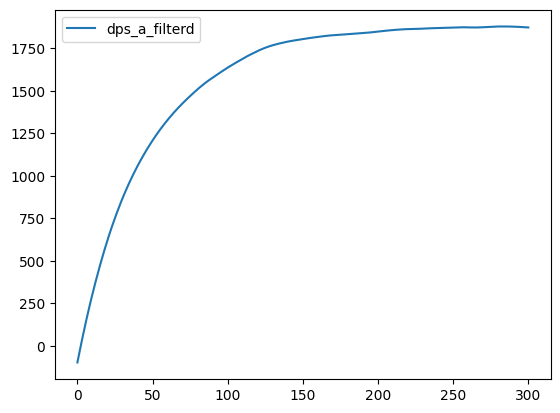

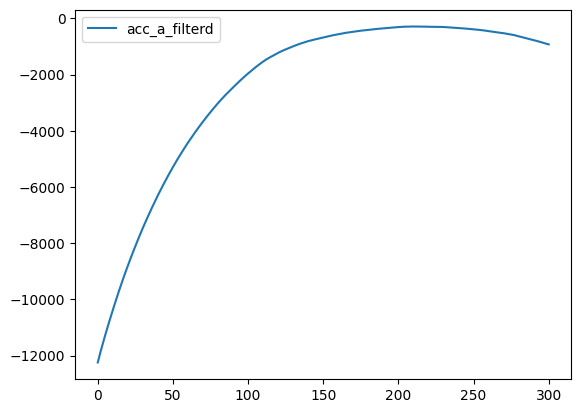

In [84]:
df2.plot(y='dps_a_filterd')
df2.plot(y='acc_a_filterd')

In [112]:
max_dps_a = df2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_b = df2['dps_b_filterd'].max()
th_b = max_dps_b * 0.632
tau_b = 0
for index, row in df2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_b_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

1877.8730147949125
1186.8157453503848
1.4710335731506334


In [103]:
#us = 7.3 * 0.5
#K = 10
# a(t) = - 1/T x v(t) + K/T x u(t)
# a(t) + 1/T x v(t) = K/T x u(t)
# a(t) x T + v(t) = K x u(t)
#for index, row in df2.iterrows():
#    print((abs(row['acc_a_filterd']) * tau_a + row['dps_a_filterd'])/K)


      100
----------------
s^2 + 17 s + 100



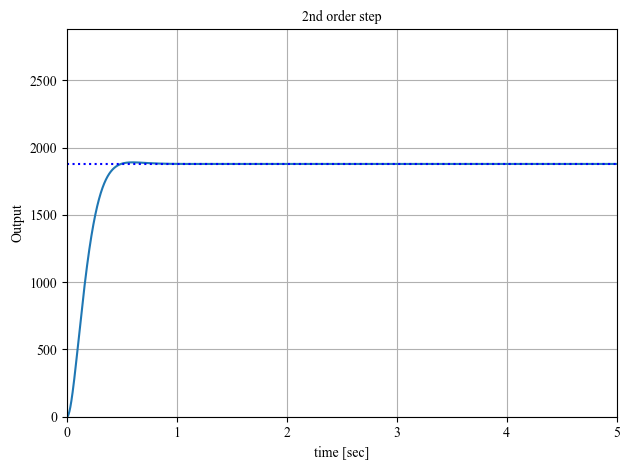

In [115]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
Kp = 10

x_max = 5
y_max = max_dps_a + 1000
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line(output, t, z_c, x_max, y_max)

In [116]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

11.807301051105242
0.5965596559655966
omega_nc : 10.005815210034871
zeta_c : 0.8502913434120307
a_m : 17.015716113746162
b_m : 10.011633801736519


In [48]:
df2

,delta,time,acc_a,dps_a,rps_a,accr_a,a_speed,delta_a_speed,delta_a_dps,delta_theata_a,...,accr_b,b_speed,delta_b_dps,delta_b_speed,delta_theata_b,b_position,acc_a_filterd,acc_b_filterd,dps_a_filterd,dps_b_filterd
0,0.272383,0.272383,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,15664.0,-12247.405026,-3391.416176,-93.380811,-62.416063
1,0.023470,0.295853,45386.368133,1065.203832,18.591314,792.141559,9.0,9.0,1065.203832,25.0,...,855.512884,11.0,1150.420138,11.0,27.0,15691.0,-12035.924051,-3321.241755,-65.110571,-34.760442
2,0.023222,0.319075,13469.323893,1377.991273,24.050485,235.084050,36.0,27.0,312.787441,32.0,...,203.401986,41.0,270.633362,30.0,33.0,15724.0,-11834.012941,-3258.790107,-37.077014,-7.347290
3,0.024566,0.343641,6874.675712,1546.872472,26.998018,119.985726,68.0,32.0,168.881199,38.0,...,2.626950,72.0,3.697460,31.0,35.0,15759.0,-11640.048308,-3201.708578,-9.389887,19.723811
4,0.023755,0.367395,7539.983253,1725.981733,30.124064,131.597533,88.0,20.0,179.109261,41.0,...,221.324270,87.0,301.230772,15.0,41.0,15800.0,-11451.190519,-3146.978472,17.905663,46.423282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.021380,7.126688,-9984.455227,1824.159513,31.837590,-174.261618,120.0,0.0,-213.464750,39.0,...,-250.628274,122.0,-307.011391,4.0,37.0,27985.0,-860.611478,-1883.448489,1840.270240,1843.639328
297,0.021384,7.148072,2167.746894,1870.515648,32.646657,37.834321,119.0,-1.0,46.356135,40.0,...,114.183948,119.0,139.902777,-3.0,40.0,28025.0,-875.818966,-1916.220831,1840.124346,1843.492625
298,0.021371,7.169443,56.636186,1871.726000,32.667781,0.988488,118.0,-1.0,1.210352,40.0,...,39.204198,116.0,48.003502,-3.0,41.0,28066.0,-890.895260,-1949.535497,1839.973653,1843.344905
299,0.023465,7.192908,3776.092679,1960.333506,34.214274,65.905250,118.0,0.0,88.607506,46.0,...,157.890053,118.0,212.278139,2.0,50.0,28116.0,-906.575737,-1984.600990,1839.809495,1843.167985


In [149]:
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
d = now.strftime('%Y-%m-%d_%H:%M:%S')
print(d)

2023-10-21_12:57:53


In [150]:
df2.to_csv('/home/uecadmin/testScript/output_mufuka_test_pwm-0.2_002_' + file_index + '_' + str(d) + '.tsv', sep='\t', index=False)